In [1]:
import torch
import cv2
import numpy as np
import glob as glob
import os
from model import build_effnet_model
from torchvision import transforms
import pandas as pd
from datasets import get_data_loaders
from PIL import Image


# Validation transforms
def get_test_transform(image_size, pretrained):
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return test_transform


# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained:  # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    else:  # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize



In [2]:
if __name__ == '__main__':


    # Constants.

    data_dir = "./data/chest_xray/"
    DEVICE = 'cpu'
    num_classes = 2
    image_size = 224

    # Class names.
    # Load the training and validation datasets.
    _, _, test_data, _, _, _ = get_data_loaders(data_dir=data_dir)

    # Class names.
    if num_classes == 2:
        class_names = ['NORMAL', 'PNEUMONIA']
    else:
        class_names = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']

    pretrained = True
    num_classes = len(class_names)
    bayes_last = False
    loss_name = "CrossEntropyLoss"

    # Load the trained model.
    model = build_effnet_model(pretrained=True, fine_tune=False, num_classes=num_classes, bayes_last=False)
    if num_classes == 2:
        try:
            checkpoint = torch.load('../results/binary/modelEfficientNet_pretrained_True_loss_CrossEntropyLoss_bayesianLast_False_numClass_2.pth', map_location=DEVICE)
        except:
            checkpoint = torch.load('./results/binary/modelEfficientNet_pretrained_True_loss_CrossEntropyLoss_bayesianLast_False_numClass_2.pth', map_location=DEVICE)
    else:
        try:
            checkpoint = torch.load('../results/multi/modelEfficientNet_pretrained_True_loss_CrossEntropyLoss_bayesianLast_False_numClass_3.pth', map_location=DEVICE)
        except:
            checkpoint = torch.load('./results/multi/modelEfficientNet_pretrained_True_loss_CrossEntropyLoss_bayesianLast_False_numClass_3.pth', map_location=DEVICE)

    print('Loading trained model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    model_name = model.__class__.__name__
    model.eval()

    # Load ground truth labels from file.
    image_label_mapping = pd.DataFrame(test_data)
    image_label_mapping = image_label_mapping.sample(5)

    # Get all the eval.py image paths.
    # all_image_paths = glob.glob(f"{DATA_PATH}/*")
    # Iterate over all the images and do forward pass.
    for i, d in enumerate(image_label_mapping.values):
        # Get the ground truth class name from the image path.
        image_path = d[0]
        gt_class_name = class_names[d[1]]

        image = Image.open(image_path).convert('RGB')
        orig_image = image.copy()
        orig_image = np.asarray(orig_image).astype(np.float32)

        # Preprocess the image
        transform = get_test_transform(image_size=image_size, pretrained=pretrained)

        image = transform(image)
        image = torch.unsqueeze(image, 0)
        image = image.to(DEVICE)

        # Forward pass through the image.
        with torch.no_grad():
            outputs = model(image)
        outputs = outputs.softmax(1).argmax(1)
        outputs = outputs.detach().numpy()
        pred_class_name = class_names[np.argmax(outputs[0])]

        print(f"GT: {gt_class_name}, Pred: {pred_class_name}")
        # Annotate the image with ground truth.
        cv2.putText(
            orig_image, f"GT: {gt_class_name}",
            (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            1.0, (0, 255, 0), 2, lineType=cv2.LINE_AA
        )
        # Annotate the image with prediction.
        cv2.putText(
            orig_image, f"Pred: {pred_class_name}",
            (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
            1.0, (100, 100, 225), 2, lineType=cv2.LINE_AA
        )
        cv2.imshow('Result', orig_image)
        cv2.waitKey(0)  # Wait indefinitely until a key is pressed
        cv2.destroyAllWindows()  # Close all OpenCV windows
        # cv2.waitKey(0)
        if num_classes == 2:
            cv2.imwrite(f"../results/binary/tests/{image_path}__{str(gt_class_name)}_{i}.png", orig_image)
            cv2.imwrite(f"./results/binary/tests/{image_path}__{str(gt_class_name)}_{i}.png", orig_image)

        else:
            cv2.imwrite(f"../results/multi/tests/{image_path}__{str(gt_class_name)}_{i}.png", orig_image)
            cv2.imwrite(f"./results/multi/tests/{image_path}__{str(gt_class_name)}_{i}.png", orig_image)


Corrected directory path to ../data/chest_xray/train/NORMAL
Corrected directory path to ../data/chest_xray/train/PNEUMONIA
Corrected directory path to ../data/chest_xray/val/NORMAL
Corrected directory path to ../data/chest_xray/val/PNEUMONIA
Corrected directory path to ../data/chest_xray/test/NORMAL
Corrected directory path to ../data/chest_xray/test/PNEUMONIA
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...
GT: PNEUMONIA, Pred: NORMAL
GT: PNEUMONIA, Pred: NORMAL
GT: NORMAL, Pred: NORMAL
GT: PNEUMONIA, Pred: NORMAL
GT: PNEUMONIA, Pred: NORMAL


: 

In [6]:
cv2.imshow('Result', orig_image)

In [9]:
cv2.imshow("a", Image.open(image_path).convert('RGB'))

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


In [25]:
a = Image.open(image_path).convert('RGB')

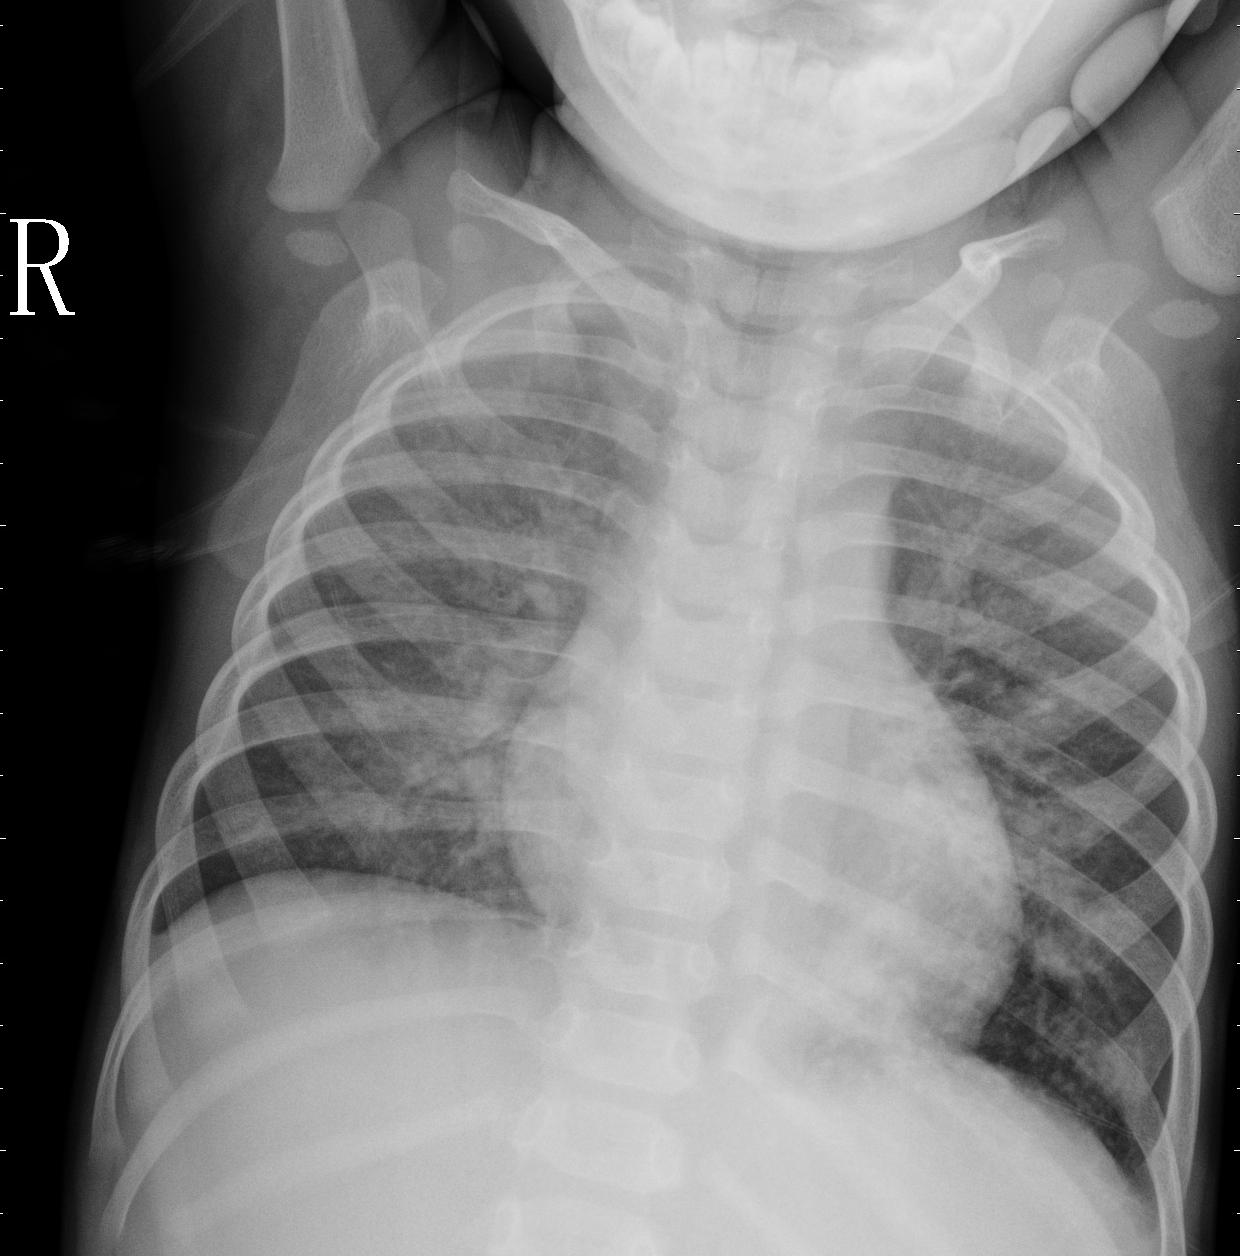

In [26]:
a

In [27]:
# a = np.asarray(a).astype(np.float32)
# a

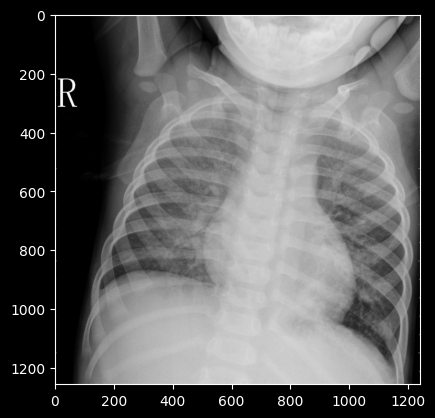

In [28]:
import matplotlib.pyplot as plt
plt.imshow(a)

TypeError: Invalid shape (3, 224, 224) for image data

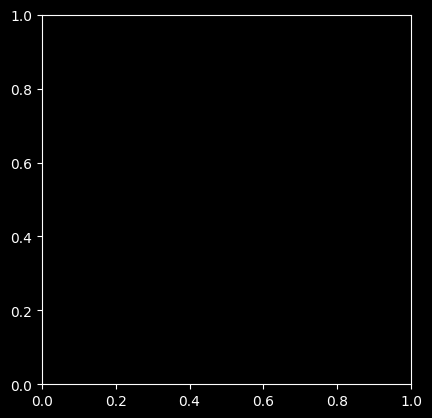

In [29]:
plt.imshow(transform(a))

In [31]:
transform(a).shape

torch.Size([3, 224, 224])

In [34]:
np.asarray(a).shape

(1256, 1240, 3)

In [45]:
b.numpy().transpose(1, 2, 0).shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


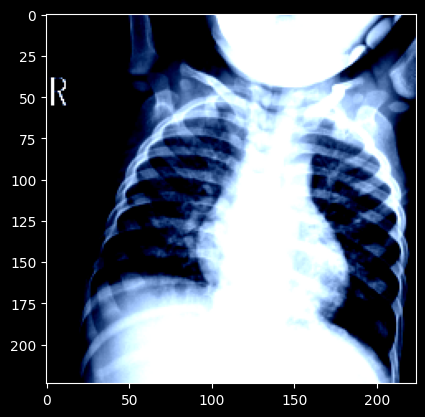

: 

In [46]:
b = transform(a)
plt.imshow(b.numpy().transpose(1, 2, 0))